In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import deepchem as dc
from tqdm import tqdm_notebook
from scipy.spatial.distance import norm

from fastai.tabular import *
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DataBunch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
TYPES              = np.array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'])
TYPES_MAP          = {t: i for i, t in enumerate(TYPES)}
SC_EDGE_FEATS      = ['type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 'dist',
                      'dist_min_rad', 'dist_electro_neg_adj', 'normed_dist', 'diangle', 'cos_angle', 
                      'cos_angle0', 'cos_angle1']
SC_MOL_FEATS       = ['type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 'dist',
                      'dist_min_rad', 'dist_electro_neg_adj', 'normed_dist', 'diangle', 'cos_angle', 
                      'cos_angle0', 'cos_angle1', 'num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 
                      'num_N_atoms', 'num_O_atoms']
N_EDGE_FEATURES    = 8
N_SC_EDGE_FEATURES = 16
N_SC_MOL_FEATURES  = 22
N_ATOM_FEATURES    = 20
N_TYPES            = len(TYPES)
N_MOLS             = 130775
SC_MEAN            = 16
SC_STD             = 35

In [3]:
# PATH = '../tmp/'
PATH = '../storage/CHAMPS/'

In [4]:
files = os.listdir(PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['structures.csv',
 'train.csv',
 'atom_df.csv',
 'test_proc_df.csv',
 'mask.csv',
 'pairs_idx.csv',
 'edge_features.csv',
 'test.csv',
 'train_proc_df.csv',
 'sample_submission.csv',
 'atomic_features.csv',
 'edge_df.csv',
 'edge_mask.csv']

## Import Data

In [5]:
train_df = pd.read_csv(PATH+'train_proc_df.csv', index_col=0)
test_df  = pd.read_csv(PATH+'test_proc_df.csv', index_col=0)
atom_df  = pd.read_csv(PATH+'atom_df.csv', index_col=0)
edge_df  = pd.read_csv(PATH+'edge_df.csv', index_col=0)

/opt/conda/envs/fastai/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train_df['scalar_coupling_constant'] = (train_df['scalar_coupling_constant'] - SC_MEAN) / SC_STD
train_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10
test_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10

## Define MPNN Model

In [7]:
def selu_weights_init(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size(1)
        m.weight.data.normal_(0.0, 1.0 / math.sqrt(fan_in))

def hidden_layer(n_in, n_out, batch_norm, dropout, act=None):
    layers = []
    layers.append(nn.Linear(n_in, n_out))
    if act: layers.append(act)
    if batch_norm: layers.append(nn.BatchNorm1d(n_out))
    if dropout != 0: layers.append(nn.Dropout(dropout))
    return layers

class FullyConnectedNet(nn.Module):
    
    def __init__(self, n_input, n_output, layers=[], act=nn.ReLU(True), dropout=[], batch_norm=False, 
                 out_act=None):
        super().__init__()
        sizes = [n_input] + layers + [n_output]
        layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout+[0.0])):
            act_ = act if i < len(layers) else out_act
            batch_norm_ = batch_norm if i < len(layers) else False
            layers_ += hidden_layer(n_in, n_out, batch_norm_, dr, act_)      
        self.layers = nn.Sequential(*layers_)
        if type(act) == nn.SELU: self.layers.apply(selu_weights_init)
        
        
    def forward(self, x):
        return self.layers(x)

In [8]:
class HiddenLSTMCell(nn.Module):
    """Implements the LSTM cell update described in the sec 4.2 of https://arxiv.org/pdf/1511.06391.pdf."""
    
    def __init__(self, n_h_out):
        """This LSTM cell takes no external 'x' inputs, but has a hidden state appended with the 
        readout from a content based attention mechanism. Therefore the hidden state is of a dimension
        that is two times the number of nodes in the set."""
        super().__init__()
        self.n_h_out, self.n_h = n_h_out, n_h_out * 2 
        self.w_h = nn.Parameter(torch.Tensor(self.n_h, n_h_out * 4))
        self.b = nn.Parameter(torch.Tensor(n_h_out * 4))
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else: 
                nn.init.zeros_(p.data)
                # initialize the forget gate bias to 1
                p.data[self.n_h_out:self.n_h_out*2] = torch.ones(self.n_h_out)
        
    def forward(self, h_prev, c_prev):
        """Takes previuos hidden and cell states as arguments and performs a 
        single LSTM step using no external input.
        """
        n_h_ = self.n_h_out # number of output hidden states
        # batch the computations into a single matrix multiplication
        gates = h_prev @ self.w_h + self.b
        i_g, f_g, g, o_g = (
            torch.sigmoid(gates[:, :n_h_]), # input
            torch.sigmoid(gates[:, n_h_:n_h_*2]), # forget
            torch.tanh(gates[:, n_h_*2:n_h_*3]),
            torch.sigmoid(gates[:, n_h_*3:]), # output
        )
        c = f_g * c_prev + i_g * g
        h = o_g * torch.tanh(c)
        return h, c

In [9]:
def scatter_add(src, idx, num):
    sz = num, src.size(1)
    exp_idx = idx[:,None].repeat(1, sz[1])
    out = torch.zeros(sz, dtype=src.dtype, device=src.device)
    return out.scatter_add(0, exp_idx, src)

def softmax(x, idx, num=None):
    x = x.exp()
    x = x / (scatter_add(x, idx, num=num)[idx] + 1e-16)
    return x
 
class Set2Set(nn.Module):
    """
    Adapted from: https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric\
        /nn/glob/set2set.html#Set2Set
    """
    def __init__(self, in_channels, proc_steps):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 2 * in_channels
        self.proc_steps = proc_steps
        self.lstm = HiddenLSTMCell(self.in_channels)

    def forward(self, x, node_idx):
        """
        x - input tensor of shape (batch_size * n_nodes, in_channels).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        """
        batch_size = node_idx.max().item() + 1
        h = torch.zeros(batch_size, self.in_channels, device=x.device)
        q_star = torch.zeros(batch_size, self.out_channels, device=x.device)
        for i in range(self.proc_steps):
            q, h = self.lstm(q_star, h)
            e = (x * q[node_idx]).sum(dim=-1, keepdim=True)
            a = softmax(e, node_idx, num=batch_size)
            r = scatter_add(a * x, node_idx, num=batch_size) # sum 'a*x' over nodes 
            q_star = torch.cat([q, r], dim=-1)
            
        return q_star

In [10]:
class EdgeNetwork(nn.Module):
    def __init__(self, n_h, n_e, n_sc_e, stride=5, net_args={}):
        super().__init__()
        self.n_h, self.stride = n_h, stride
        self.adj_net = FullyConnectedNet(n_e, n_h*stride, **net_args)
        self.sc_adj_net = FullyConnectedNet(n_sc_e, n_h*stride, **net_args)
        self.b = nn.Parameter(torch.Tensor(n_h)) # bias for the message function
        nn.init.zeros_(self.b)
    
    def forward(self, h, e, sc_e, pairs_idx, sc_pairs_idx, t=0):
        """
        Compute message vector m_t given the previuos hidden state
        h_t-1 and edge features e.
        - h: tensor of hidden states of shape (batch_size * n_nodes, n_h)
        - e: tensor of edge features of shape (batch_size * n_edges, n_e).
        - sc_e: tensor of scalar coupling edge features of shape 
            (batch_size * n_sc, n_sc_e).
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - t: update iteration. 
        """
        # compute 'A(e)'
        if t==0: 
            self.a_mat = self.get_a_mat(self.adj_net(e))
            self.a_sc_mat = self.get_a_mat(self.sc_adj_net(sc_e))
            
        # compute 'm_{i} = sum_{j in N(i)}(A_{ij}h_{j})' for all nodes 'i'
        m = self.add_message(torch.zeros_like(h), self.a_mat, h, pairs_idx)
        m = self.add_message(m, self.a_sc_mat, h, sc_pairs_idx)
        return m + self.b # add message bias
    
    def get_a_mat(self, a_vect):
        return a_vect.view(-1, self.n_h, self.stride) / (self.stride ** .5)
    
    def add_message(self, m, a, h, pairs_idx):
        # transform 'pairs_idx' and 'a' to make messages go both in to and out of all nodes
        in_out_idx = torch.cat((pairs_idx, pairs_idx[:, [1, 0]]))
        a_ = torch.cat((a, a)) 
        
        # select the 'h_{j}' feeding into the 'm_{i}'
        h_in = h.index_select(0, in_out_idx[:,1])
        
        # do the matrix multiplication 'A_{ij}h_{j}'
        h_unfolded = F.pad(h_in, 2*(self.stride//2, )).unfold(1, self.stride, 1)
        ah = (h_unfolded * a_).sum(-1) # ah = (h_in.unsqueeze(1) @ a_).squeeze(1)
        
        # Sum up all 'A_{ij}h_{j}' per node 'i'
        return m.scatter_add(0, in_out_idx[:,0,None].repeat(1, self.n_h), ah)      

In [11]:
class GRUUpdate(nn.Module):
    def __init__(self, n_h):
        super().__init__()
        self.gru = nn.GRUCell(n_h, n_h)
        
    def forward(self, m, h_prev):
        """
        Update hidden state h.
        - h_prev is vector of hidden states of shape (batch_size * n_nodes, n_h)
        - m is vector of messages of shape (batch_size * n_nodes, n_h)
        """
        return self.gru(m, h_prev)

In [46]:
class MyCustomHead(nn.Module):
    def __init__(self, n_input, n_output, pre_layers=[], post_layers=[], act=nn.ReLU(True), dropout=[], 
                 batch_norm=False):
        super().__init__()
        sizes, n_pre_layers = [n_input] + pre_layers, len(pre_layers)
        pre_layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout[:n_pre_layers])):
            pre_layers_ += hidden_layer(n_in, n_out, batch_norm, dr, act)      
        self.preproc = nn.Sequential(*pre_layers_)
        self.postproc = nn.ModuleList([
            FullyConnectedNet(pre_layers[-1], n_output, post_layers, act, dropout[n_pre_layers:], batch_norm=False)
            for _ in range(N_TYPES)
        ])
        
    def forward(self, x, sc_types):
        x_ = self.preproc(x)
        y = torch.zeros(sc_types.size(0), device=x.device)
        for i in range(N_TYPES):
            if torch.any(sc_types == i): 
                y[sc_types == i] = self.postproc[i](x_[sc_types == i]).view(-1)
        return y        

In [47]:
class Set2SetOutput(nn.Module):
    def __init__(self, n_x, n_h, n_sc_m, proc_steps, net_args):
        super().__init__()
        self.R_proj = nn.Linear(n_h + n_x, n_h)
        self.R_proc = Set2Set(n_h, proc_steps)
        self.R_write = MyCustomHead((4 * n_h) + n_sc_m, 1, **net_args)
    
    def forward(self, h, x, sc_m, node_idx, sc_idx, sc_pairs_idx, sc_types):
        """
        Make prediction.
        - h is vector of hidden states of shape (batch_size * n_nodes, n_h).
        - x is vector of input features of shape (batch_size * n_nodes, n_x).
        - sc_m: tensor of scalar coupling molecule level features of shape 
            (batch_size * n_sc, n_sc_m).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        - sc_idx: tensor of shape (batch_size * n_sc) mapping each
            scalar coupling constant to its corresponding index in the batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        m = self.R_proj(torch.cat([h, x], dim=1))
        q = self.R_proc(m, node_idx)
        
        # introduce skip connection to final node states of scalar coupling atoms
        inp = torch.cat([
            q.index_select(0, sc_idx),
            h.index_select(0, sc_pairs_idx[:,0]),
            h.index_select(0, sc_pairs_idx[:,1]),
            sc_m
        ], dim=-1)
        y = self.R_write(inp, sc_types)
        return y

In [48]:
class MPNN(nn.Module):
    def __init__(self, n_x, n_h, n_e, n_sc_e, n_sc_m, stride=5, update_steps=3, proc_steps=10, 
                 preproc_net_args={}, enn_args={}, R_net_args={}):
        super().__init__()
        self.preproc_net = FullyConnectedNet(n_x, n_h, **preproc_net_args)
        self.M = EdgeNetwork(n_h, n_e, n_sc_e, stride, enn_args)
        self.U = GRUUpdate(n_h)
        self.R = Set2SetOutput(n_x, n_h, n_sc_m, proc_steps, R_net_args)
        self.update_steps = update_steps
        
    def forward(self, x, e, sc_e, sc_m, node_idx, pairs_idx, sc_idx, sc_pairs_idx, sc_types):
        """
        Args:
        - x: tensor of node features of shape (batch_size * n_nodes, n_x).
        - e: tensor of edge features of shape (batch_size * n_edges, n_e).
        - sc_e: tensor of scalar coupling edge features of shape 
            (batch_size * n_sc, n_sc_e).
        - sc_m: tensor of scalar coupling molecule level features of shape 
            (batch_size * n_sc, n_sc_m).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_idx: tensor of shape (batch_size * n_sc) mapping each
            scalar coupling constant to its corresponding index in the batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        h = self.preproc_net(x)
        for t in range(self.update_steps):
            m = self.M(h, e, sc_e, pairs_idx, sc_pairs_idx, t)
            h = self.U(m, h)
        y = self.R(h, x, sc_m, node_idx, sc_idx, sc_pairs_idx, sc_types)
        return y

##  Fit MPNN

In [49]:
def set_seed(seed=100):
    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    np.random.seed(seed)

In [50]:
mol_ids = train_df['molecule_id'].unique()
n_obs = len(mol_ids)
split = int(n_obs*0.75)
set_seed(100)
mol_ids_ = np.random.choice(mol_ids, size=n_obs, replace=False)
train_mol_ids, val_mol_ids = pd.Series(mol_ids_[:split]), pd.Series(mol_ids_[split:])

In [51]:
gb_mol_sc = train_df.groupby('molecule_id')
test_gb_mol_sc = test_df.groupby('molecule_id')
gb_mol_atom = atom_df.groupby('molecule_id')
gb_mol_edge = edge_df.groupby('molecule_id')

In [52]:
def one_hot_encode_np(x):
    sz = len(x), len(np.unique(x))
    x_one_hot = np.zeros(sz, dtype=np.long)
    x_one_hot[np.arange(sz[0]), x] = 1
    return x_one_hot

class MoleculeDataset(Dataset):
    
    def __init__(self, mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge):
        self.n = len(mol_ids)
        self.mol_ids = mol_ids
        self.gb_mol_sc = gb_mol_sc
        self.gb_mol_atom = gb_mol_atom
        self.gb_mol_edge = gb_mol_edge

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return (self.gb_mol_sc.get_group(self.mol_ids[idx]), 
                self.gb_mol_atom.get_group(self.mol_ids[idx]), 
                self.gb_mol_edge.get_group(self.mol_ids[idx]))

def np_lst_to_torch(arr_lst, dtype=torch.float):
    return torch.from_numpy(np.ascontiguousarray(np.concatenate(arr_lst))).type(dtype)

def collate_fn(batch):
    batch_size, n_atom_sum = len(batch), 0
    x, e, sc_e, sc_m, sc_types, sc_vals = [], [], [], [], [], []
    node_idx, pairs_idx, sc_pairs_idx, sc_idx = [], [], [], []

    for b in range(batch_size):
        sc_df, atom_df, edge_df = batch[b]
        n_atoms, n_sc = len(atom_df), len(sc_df)
        
        x.append(atom_df.drop(columns='molecule_id').values)
        e.append(edge_df.drop(columns=['idx_0', 'idx_1', 'molecule_id']).values)
        sc_e.append(sc_df[SC_EDGE_FEATS].values)
        sc_m.append(sc_df[SC_MOL_FEATS].values)
        sc_types.append(sc_df['type'].values)
        sc_vals.append(sc_df['scalar_coupling_constant'].values)
        
        node_idx.append(np.repeat(b, n_atoms))
        sc_idx.append(np.repeat(b, n_sc))
        pairs_idx.append(edge_df[['idx_0', 'idx_1']].values + n_atom_sum)
        sc_pairs_idx.append(sc_df[['atom_index_0', 'atom_index_1']].values + n_atom_sum)
        
        n_atom_sum += n_atoms
    
    x, e = np_lst_to_torch(x), np_lst_to_torch(e), 
    sc_e, sc_m = np_lst_to_torch(sc_e), np_lst_to_torch(sc_m)
    sc_vals, sc_types = np_lst_to_torch(sc_vals), np_lst_to_torch(sc_types, torch.long)
    node_idx = np_lst_to_torch(node_idx, torch.long)
    sc_idx = np_lst_to_torch(sc_idx, torch.long)
    pairs_idx = np_lst_to_torch(pairs_idx, torch.long)
    sc_pairs_idx = np_lst_to_torch(sc_pairs_idx, torch.long)
    
    return (x, e, sc_e, sc_m, node_idx, pairs_idx, sc_idx, sc_pairs_idx, sc_types), sc_vals

In [53]:
batch_size = 20

In [54]:
train_ds = MoleculeDataset(train_mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge)
val_ds   = MoleculeDataset(val_mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size, num_workers=8, drop_last=True)
db = DataBunch(train_dl, val_dl, collate_fn=collate_fn)

In [55]:
batch = next(iter(train_dl))

In [56]:
for el in batch[0]: print(el.size())
print(batch[1].size())

torch.Size([375, 20])
torch.Size([387, 8])
torch.Size([1144, 16])
torch.Size([1144, 22])
torch.Size([375])
torch.Size([387, 2])
torch.Size([1144])
torch.Size([1144, 2])
torch.Size([1144])
torch.Size([1144])


In [57]:
b_dict = dict(x=batch[0][0], 
              e=batch[0][1], 
              sc_e=batch[0][2], 
              sc_m=batch[0][3], 
              node_idx=batch[0][4], 
              pairs_idx=batch[0][5], 
              sc_idx=batch[0][6], 
              sc_pairs_idx=batch[0][7], 
              sc_types=batch[0][8], 
              sc_vals=batch[1])
for k,v in b_dict.items(): print(f'{k}:\n {v}')

x:
 tensor([[0.0000, 1.0000, 0.0000,  ..., 1.2037, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 1.3965, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 1.2018, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..., 1.0617, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 1.0785, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 1.0802, 0.0000, 0.0000]])
e:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.5316,  1.3957],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0947, -0.7402],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0948, -0.7397],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.3961,  0.9587],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.3049,  0.2646],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0802, -1.4458]])
sc_e:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.3127],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.3438,  0.7481, -0.7354],
        [ 0.0

In [58]:
def group_mean_log_mae(y_true, y_pred, types):
    proc = lambda x: x.cpu().numpy().ravel() 
    y_true, y_pred, types = proc(y_true), proc(y_pred), proc(types)
    y_true = SC_MEAN + y_true * SC_STD
    y_pred = SC_MEAN + y_pred * SC_STD
    maes = pd.Series(y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes).mean()

class GroupMeanLogMAE(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['group_mean_log_mae'])
    def on_epoch_begin(self, **kwargs): self.input, self.output, self.target = [], [], []
    
    def on_batch_end(self, last_target, last_output, last_input, train, **kwargs):
        if not train:
            self.input.append(last_input[-1])
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if (len(self.input) > 0) and (len(self.output) > 0):
            inputs = torch.cat(self.input)
            preds = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = group_mean_log_mae(preds, target, inputs)
            return add_metrics(last_metrics, [metric])

In [65]:
wd, batch_norm, act = 0, True, nn.ReLU(True)
stride, update_steps, proc_steps = 5, 5, 10
n_x, n_h, n_e, n_sc_e, n_sc_m = N_ATOM_FEATURES, 150, N_EDGE_FEATURES, N_SC_EDGE_FEATURES, N_SC_MOL_FEATURES
preproc_net_args = dict(layers=[], act=act, dropout=[], batch_norm=batch_norm, out_act=nn.Tanh())
enn_args = dict(layers=3*[n_h], act=act, dropout=3*[0.0], batch_norm=batch_norm)
R_net_args = dict(pre_layers=[1000], post_layers=[500], act=act, dropout=[0.0, 0.0], batch_norm=batch_norm)

In [66]:
set_seed(100)
model = MPNN(n_x, n_h, n_e, n_sc_e, n_sc_m, stride, update_steps, proc_steps, preproc_net_args, enn_args, R_net_args)

In [67]:
print(model)
print(model(*batch[0]))
print(model(*batch[0]).size())

MPNN(
  (preproc_net): FullyConnectedNet(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=150, bias=True)
      (1): Tanh()
    )
  )
  (M): EdgeNetwork(
    (adj_net): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=8, out_features=150, bias=True)
        (1): ReLU(inplace)
        (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=150, out_features=150, bias=True)
        (4): ReLU(inplace)
        (5): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_features=150, out_features=150, bias=True)
        (7): ReLU(inplace)
        (8): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Linear(in_features=150, out_features=750, bias=True)
      )
    )
    (sc_adj_net): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=16, out_features=150, b

In [68]:
learn = Learner(db, model, metrics=[mean_absolute_error], callback_fns=GroupMeanLogMAE, 
                wd=wd, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


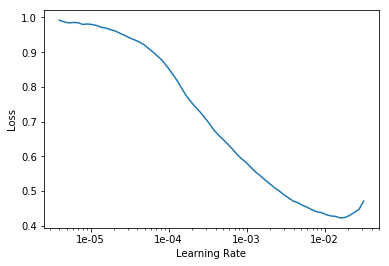

In [63]:
learn.lr_find(start_lr=1e-6, end_lr=1.0, num_it=100, stop_div=True)
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(20, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn1')])

epoch,train_loss,valid_loss,mean_absolute_error,group_mean_log_mae,time
0,0.040078,0.033600,0.022797,-0.317368,04:31
1,0.039981,0.036785,0.023633,-0.403641,04:31
2,0.036716,0.031744,0.022062,-0.339929,04:33
3,0.034747,0.026544,0.018242,-0.602482,04:32
4,0.031141,0.024579,0.015550,-0.685172,04:33
5,0.025579,0.023645,0.015542,-0.704422,04:31
6,0.024146,0.023972,0.014393,-0.793374,04:31
7,0.021563,0.020310,0.012977,-0.875626,04:32
8,0.019448,0.017468,0.011329,-1.044839,04:33
9,0.018570,0.017831,0.010775,-1.034339,04:34


Better model found at epoch 0 with group_mean_log_mae value: -0.31736767292022705.
Better model found at epoch 1 with group_mean_log_mae value: -0.40364134311676025.
Better model found at epoch 3 with group_mean_log_mae value: -0.6024815440177917.
Better model found at epoch 4 with group_mean_log_mae value: -0.6851716041564941.
Better model found at epoch 5 with group_mean_log_mae value: -0.7044216394424438.
Better model found at epoch 6 with group_mean_log_mae value: -0.7933740019798279.
Better model found at epoch 7 with group_mean_log_mae value: -0.8756258487701416.
Better model found at epoch 8 with group_mean_log_mae value: -1.0448390245437622.
Better model found at epoch 10 with group_mean_log_mae value: -1.0489181280136108.
Better model found at epoch 11 with group_mean_log_mae value: -1.2090023756027222.
Better model found at epoch 12 with group_mean_log_mae value: -1.2886521816253662.
Better model found at epoch 13 with group_mean_log_mae value: -1.3127251863479614.
Better mod

KeyboardInterrupt: 

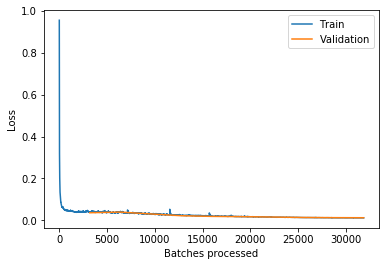

In [31]:
learn.recorder.plot_losses(skip_start=100)

In [33]:
learn.fit_one_cycle(10, max_lr=6e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn2')])

epoch,train_loss,valid_loss,mean_absolute_error,group_mean_log_mae,time
0,0.015523,0.016465,0.010963,-1.053521,03:57
1,0.016273,0.015719,0.010522,-1.095065,03:59
2,0.015880,0.016411,0.011262,-0.995226,03:59
3,0.014817,0.015940,0.010395,-1.136401,03:59
4,0.013509,0.013581,0.008907,-1.268452,04:00
5,0.012550,0.012496,0.008149,-1.350428,04:00
6,0.011763,0.012394,0.007979,-1.407910,04:00
7,0.010631,0.013680,0.007637,-1.391376,04:03
8,0.009858,0.010984,0.006933,-1.536116,04:16
9,0.009683,0.011111,0.006870,-1.549529,04:00


Better model found at epoch 0 with group_mean_log_mae value: -1.0535207986831665.
Better model found at epoch 1 with group_mean_log_mae value: -1.095064640045166.
Better model found at epoch 3 with group_mean_log_mae value: -1.1364011764526367.
Better model found at epoch 4 with group_mean_log_mae value: -1.2684519290924072.
Better model found at epoch 5 with group_mean_log_mae value: -1.3504276275634766.
Better model found at epoch 6 with group_mean_log_mae value: -1.4079095125198364.
Better model found at epoch 8 with group_mean_log_mae value: -1.536116123199463.
Better model found at epoch 9 with group_mean_log_mae value: -1.54952871799469.


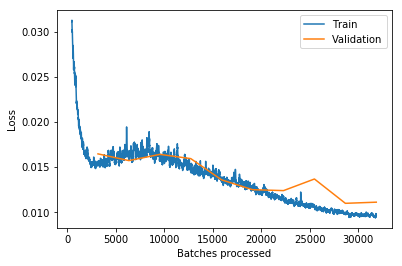

In [42]:
learn.recorder.plot_losses(500)

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn3')])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn4')])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
pred, _ = learn.get_preds()
pred_test, _ = learn.get_preds(DatasetType.Test)